# High Accuracy Cancer Prediction Using Machine Learning Inspired Mass Spectrum Analysis

###### Peter Liu 6/18/2018

Early detection and treatment of cancer is essential to increase survival rate and life quality of patients with cancer. However, diagnosis of cancer includes PET/CT scans or surgery, which is highly costive to both hospitals and patients. Instead, mass spectroscopy turned out to be an affordable and fast instrument to collect mass spectrum data from saliva or other excretes, and the data were analyzed to predict cancer. In particular, mass spectroscopy equiped with robotic sample preparation offered a high-throughput and reliable solution for data collection. However, although **mass spectroscopy** has been widely applied in industries, such as food, pharmaceutical, petrochemical, coating and semiconductor areas, it **needs professionals to interpret the mass spectra in order to identify the useful information**.<br><br> Herein, we offered a <font color = red>fast and high accuracy cancer prediction product</font> (*APP and Web*) to interpret mass spectrum. This app will not only offer *intuitive interpretion* of mass spectra data for less-experienced people, but also be a *powerful tool* for professionals to discover fingerprint molecules for cancer diagnosis.
***

<a id='TOC'></a>
## ** Table of Contents**
- [**1. Data Wrangling**](#data_wrangling)
  * [1.1 Data Wrangling with one sample](#data_import_single)<br>
    **o** [Mass range selection](#mass_selection_single)<br>
    **o** [Baseline substraction](#baseline_substraction_single)<br>
    **o** [Rescale](#rescale_single)<br>
    **o** [Visualization](#spectrum_image_single)<br>
    **o** [Transform to 'wider' form](#transform_single)<br>
  * [1.2 Data Wrangling with multiple files](#data_import_multi)<br>
    **o** [Define method to transform and combine multiple spectrum files](#method_transform_combine)<br>
    **o** [Create robotic prepared samples dataset](#create_robotic)<br>
    **o** [Create hand prepared samples dataset](#create_hand)<br>
    **o** [Create prostate samples dataset](#create_prostate)<br>
- [**2. Exploratary Data Analysis**](#eda)
  * [2.1 Visualization](#visualization)<br>
  * [2.2 Visualization by first two principle components](#pca_visualization)<br>
- [**3. Deep Analysis using Machine Learning Algorithm**](#ml)
  * [3.1 Feature Selection](#feature_selection)<br>
  * [3.2 Modeling](#models)<br>
  * [3.3 Comparison of Model Performance](#performance)<br>
- [**4. Extended Questions**](#extendedquestions)<br>
  * [4.1 Is ensemble model better than single model for cancer prediction?](#ensemble)<br>
  * [4.2 Can you tell if a new sample could be used for cancer prediction using your model?](#aliensample)<br>
  * [4.3 If samples were accidentally mixed up, can you tell if it is ovarian or prostate cancer?](#mixup)<br>
  * [4.4 What are the fingerprint molecules that determine ovarian cancer and prostate cancer?](#fingerprintmolecule)<br>
  * [4.5 What is the advantange of using robotic sample preparation over sample preparation by hand?](#roboticvshand)<br>
- [**5. Conclusion**](#conclusion)
  ***

This is a data set of mass spectra of samples from cancer patients and healthy people. We would like to build ML model to predict cancer within each group (i.g., Robotic prepared ovarian cancer dataset, Hand prepared ovarian cancer dataset, and Prostate cancer dataset), and also predict what kind of cancer if group is unknown.

**Original mass spectra** are downloaded from https://home.ccr.cancer.gov/ncifdaproteomics/ppatterns.asp
Also available through https://github.com/liudj2008/CapstoneProject1

**General knowledge** on mass spectrometry was referenced here: https://en.wikipedia.org/wiki/Mass_spectrometry

**Reference paper** is available through https://academic.oup.com/ajcp/article/134/6/903/1760577 The authors used other detection methods (e.g., HPLC-HRMS) to collect mass spectrum data from other ovarian cancer patients. Interestingly, their results closely agree with our discovery using public data

- **Robotic prepared ovarian cancer dataset** (Ovarian Dataset 8-7-02.zip):

Samples were prepared by robotic sample handling (washing, incubation, etc) and the spectra were collected by WCX2 chip and PBSII SELDI-TOF mass spectrometer. The sample set included 91 controls(no cancer) and 162 ovarian cancers.


- **Hand prepared ovarian cancer dataset** (Ovarian Dataset 4-3-02.zip)

Samples were processed by hand before analysis by mass spectroscopy. The WCX2 chip was prepared by hand using the recommended protocol. The sample set included 100 controls and 100 ovarian cancers.

-  **Prostate cancer dataset**(JNCI Dataset 7-3-02.zip)

This data was collected using the H4 protein chip and a Ciphergen PBS1 SELDI-TOF mass spectrometer. The chip was prepared by hand using the recommended protocol. The spectra were exported with the baseline subtracted. The goal of this feasibility study was to explore the existence of low molecular weight information that could serve as a diagnostic classifier, using a defined study set as a test ground.The sample set included 63 controls and 69 prostate cancers.

<a id="data_wrangling"></a>
# [1. Data Wrangling](#TOC)

Original data were 2024 csv files. Each csv file represents the mass spectrum collected from one patient. This is a common way to store data for analysis instruments.

### A typical dataset was group of several csv files
<img src='Figures/Samples.png'></img>
***

### Single csv file records M/Z and Peak Intensity
M/Z represents the mass of molecules, intensity represents the signal intensity obtained by the intruments. As you can see, mass spectrum is with high accuracy, it can differentiate molecules with tiny difference in molecular weight. The drawback of high sensitivity is that it sometimes comes with low selectivity (percentage of TN over sum of TN and FP), so it needs professionals to identify useful information.
<img src='Figures/Single excel.png'></img>
***

<a id='data_import_single'></a>
## [1.1 Data Import, Cleaning and Transformation (Trial with one sample)](#TOC)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
% matplotlib inline

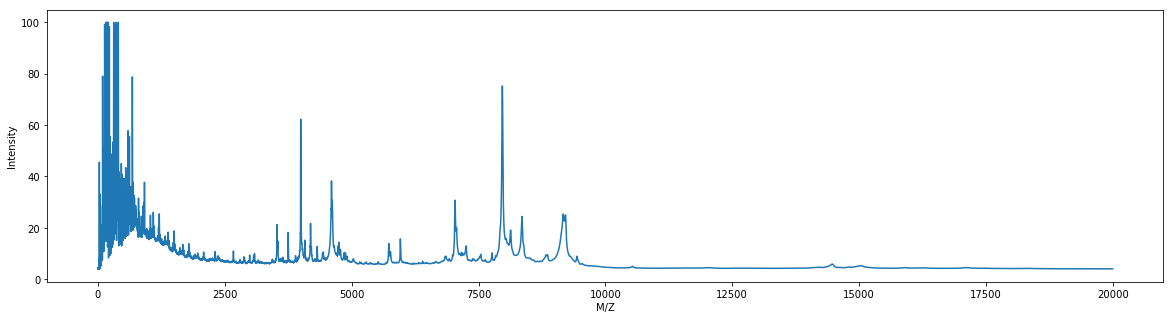

In [2]:
# Read cancer spectrum into pd dataframe
df = pd.read_csv('Database used\OvarianDataset_Robotic Handled\Cancer\Ovarian Cancer daf-0601.csv')

# Plot the Mass Spectrum
plt.figure(figsize=[20,5])
plt.plot(df['M/Z'], df['Intensity'])
plt.xlabel('M/Z')
plt.ylabel('Intensity')
plt.savefig('Figures/Mass Spectrum.png')

<a id = 'mass_selection_single'></a>
#### Step 1. The mass less than 200 (matrix interference) and mass over 10000 provide weak or no information, so I removed points in the above regions

In [3]:
# Select regions where 200 < M/Z < 10000
df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
df.head()

,M/Z,Intensity
1517,200.17821,100.000000
1518,200.44238,100.000000
1519,200.70672,100.000000
1520,200.97123,99.929613
1521,201.23592,99.702363


<a id = 'baseline_substraction_single'></a>
#### Step 2. Baseline substraction: Subtracted in a window the median of the 20% smallest values

In [4]:
# Compute the median value of the 20% smallest values
median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
print('The median intensity of the 20% smallest intensity is: {}'.format(median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)

df.head()

The median intensity of the 20% smallest intensity is: 6.1987597


,M/Z,Intensity
1517,200.17821,93.801240
1518,200.44238,93.801240
1519,200.70672,93.801240
1520,200.97123,93.730853
1521,201.23592,93.503603


<a id='rescale_single'></a>
#### Step 3. Re-scaling and taking the square root: The spectra were divided by the median of the 5% top values, and the square root of the all values was taken.

In [5]:
# Compute the median value of the top 5% intensity values
top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
print('The median intensity of the top 5% intensity is: {}'.format(top_median))

# Construct new data frame using updated Intensity
df.Intensity = df.Intensity.apply(lambda x: x/top_median)
df.Intensity = np.sqrt(df.Intensity)

df.head()

The median intensity of the top 5% intensity is: 31.6866098


,M/Z,Intensity
1517,200.17821,1.720546
1518,200.44238,1.720546
1519,200.70672,1.720546
1520,200.97123,1.719901
1521,201.23592,1.717815


<a id='spectrum_image_single'></a>
#### Step 4. Some intuitive plotting and imaging the sepctrum data
The more yellow the region is, the higher intensity of the M/Z. Notice that there are several regions of dark blue indicating that the intensity is essentially 0.

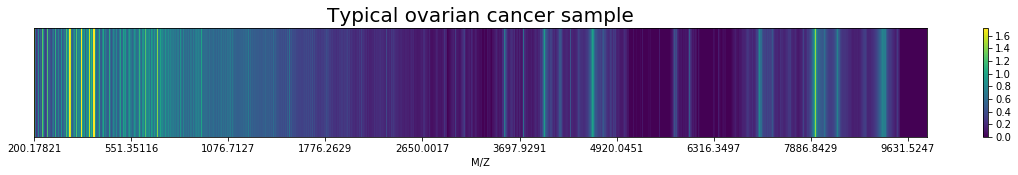

In [6]:
# Plot the heatmap of M/Z of mass spectrum
plt.figure(figsize=[20,2])
plt.title('Typical ovarian cancer sample', fontsize = 20)
plt.imshow(df.Intensity[np.newaxis,:], aspect="auto")
plt.yticks([])
plt.xticks(np.arange(0, 9200, 1000), df['M/Z'][0:9200:1000])
plt.colorbar()
plt.xlabel('M/Z')
plt.savefig('Figures/Spectrum Projection.png')

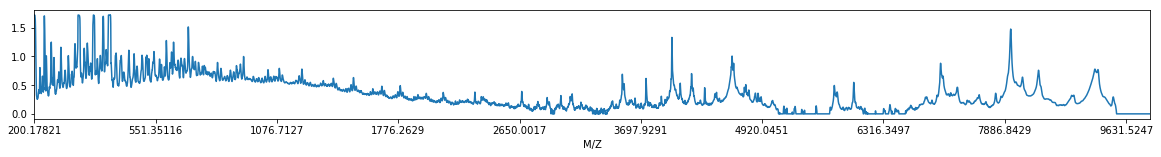

In [7]:
# Plot modified mass spectrum
plt.figure(figsize=[20,2])
plt.plot(range(len(df['M/Z'])), df.Intensity)
plt.xlabel('M/Z')
plt.xlim(0, len(df['M/Z']))
_ = plt.xticks(np.arange(0, 9200, 1000), df['M/Z'][0:9200:1000])

<a id = 'transform_single'></a>
#### Step 5. Transform the dataframe to a 'wider' form

In [8]:
# Pivot the dataframe, making the dataframe a 'wider' form
df_transform= df.pivot_table(columns='M/Z')
df_transform = df_transform.reset_index().iloc[:,1:]

In [9]:
# A wide format of M/Z ratio
df_transform

M/Z,200.17821,200.44238,200.70672,200.97123,201.23592,201.50078,201.76582,202.03103,202.29642,202.56198,...,9982.7063,9984.5713,9986.4364,9988.3017,9990.1672,9992.0328,9993.8987,9995.7647,9997.6308,9999.4972
0,1.720546,1.720546,1.720546,1.719901,1.717815,1.713023,1.692505,1.672132,1.63622,1.560843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='data_import_multi'></a>
## [1.2 Data Import, Cleaning, Transformation and Concat (Mutiple files)](#TOC)

<a id = 'method_transform_combine'></a>
#### Step 1. Define methods to transform and combine multiple spectrum files

In [10]:
# Define methods to transform single csv file to wider form
def data_transform(path):
    # Read csv file
    df = pd.read_csv(path)
    df.columns = ['M/Z', 'Intensity']
    
    # Select mass window between 200 and 10000
    df = df[(df['M/Z']>200) & (df['M/Z']<10000)]
    
    # Baseline substration. Substract the spectra with the median of lowest 20% intensity
    median = np.median(np.sort(df.Intensity)[:(len(df.Intensity)//5)])
    df.Intensity = df.Intensity.apply(lambda x: x-median if (x-median)>=0 else 0)
    
    # Rescale by dividing the intensity with the median of top 5% intensity and take the rootsqure
    top_median = np.median(np.sort(df.Intensity)[::-1][:(int(len(df.Intensity)*0.05))])
    df.Intensity = df.Intensity.apply(lambda x: x/top_median)
    df.Intensity = np.sqrt(df.Intensity)
    
    # Pivot table and return the resulting data frame
    df_transform= df.pivot_table(columns='M/Z')
    df_transform = df_transform.reset_index().iloc[:,1:]
    
    return df_transform

In [11]:
# Define methods to transform and concat all dataframe to one single dataframe
def transform_combine_spectra(folder):    
    csv_list = glob.glob('Database used\\'+ folder + '\**\*.csv', recursive=True)
    df = pd.DataFrame()
    for csv_file in csv_list:
        temp = data_transform(csv_file)
        df_update = pd.concat((df, temp), ignore_index=True)
        if np.any(df.isnull()):
            print('There is mismatch of data points!')
            break
        else:
            df = df_update
    return df

<a id = 'create_robotic'></a>
#### Step 2. Create robotic prepared ovarian data

In [12]:
# Spectra data for cancer group
cancer_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Cancer')

# Spectra data for non cancer group
control_group = transform_combine_spectra('OvarianDataset_Robotic Handled\Control')

# Store into pickle file
import pickle
with open('pickle/ovarian_robotic.pickle','wb') as f:
    pickle.dump([cancer_group, control_group], f)

<a id = 'create_hand'></a>
#### Step 3. Create hand prepared ovarian data

In [13]:
cancer_group_hand = transform_combine_spectra('OvarianData_Hand Handled\Cancer')

control_group_hand = transform_combine_spectra('OvarianData_Hand Handled\Control')

# Store into pickle file
import pickle
with open('pickle/ovarian_hand.pickle','wb') as f:
    pickle.dump([cancer_group_hand, control_group_hand], f)

<a id = 'create_prostate'></a>
#### Step 4. Create prostate data

In [14]:
# Spectra data for cancer group
cancer_group_prostate = transform_combine_spectra('JNCI_Data_7-3-02\Cancer')

# Spectra data for non cancer group
control_group_prostate = transform_combine_spectra('JNCI_Data_7-3-02\Control')

# Store into pickle file
import pickle
with open('pickle/prostate.pickle','wb') as f:
    pickle.dump([cancer_group_prostate, control_group_prostate], f)

<a id = 'eda'></a>
# [2. Exploratary Data Analysis (EDA) of three data sets](#TOC)

In [15]:
# Define method of creating data and labels
def create_data_label(cancer_group, control_group):
    data = pd.concat((cancer_group, control_group), ignore_index=True)
    label = np.concatenate((np.repeat(1, cancer_group.shape[0]), np.repeat(-1, control_group.shape[0])))
    return data, label

In [16]:
# Define method of plotting spectra heatmap
def heatmap(cancer_group, control_group):
    plt.figure(figsize=[20,10])

    # Cancer group spectra
    plt.subplot(211)
    plt.title('Cancer group', fontsize = 20)

    plt.imshow(cancer_group, aspect='auto')
    plt.xticks(np.arange(0, 9200, 1000), cancer_group.columns[0:9200:1000])
    plt.yticks(np.arange(0,len(cancer_group)+1, 10))
    plt.xlabel('M/Z')
    plt.ylabel('Samples')
    plt.colorbar()

    # Non-cancer group spectra
    plt.subplot(2,1,2)
    plt.title('Control group', fontsize = 20)
    plt.imshow(control_group, aspect='auto')
    plt.xticks(np.arange(0, 9200, 1000), control_group.columns[0:9200:1000])
    plt.yticks(np.arange(0,len(control_group),10))
    plt.xlabel('M/Z')

    plt.ylabel('Samples')
    plt.colorbar()

    plt.tight_layout()
    plt.savefig('Figures/Sample comparison.png')

In [17]:
# Create data and labels for robotic prepared samples, hand prepared ovarian samples and prostate samples
ovarian_data, ovarian_label = create_data_label(cancer_group, control_group)
prostate_data, prostate_label = create_data_label(cancer_group_prostate, control_group_prostate)
ovarian_data_hand, ovarian_label_hand = create_data_label(cancer_group_hand, control_group_hand)

<a id='visualization'></a>
### [2.1 Visualization of mass spectra for ovarian samples and prostate samples](#TOC)
We can easily tell that robotic prepared samples are much more consistant than hand prepared samples: Robotic prepared samples showed less variance among samples.

* Spectra heatmap of ovarian samples

Robotic Prepared Ovarian Samples


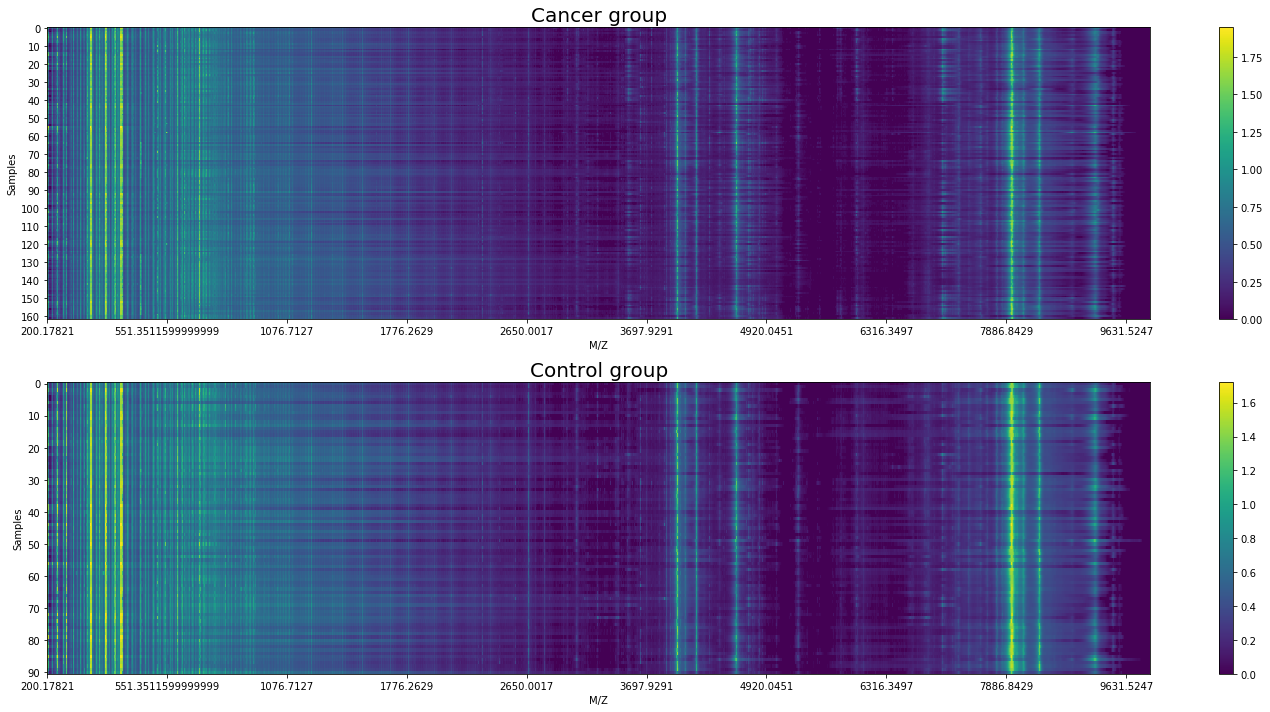

In [18]:
print('Robotic Prepared Ovarian Samples')
print('='*100)
heatmap(cancer_group, control_group)

* Spectra heatmap of hand prepared ovarian samples

Hand Prepared Ovarian Samples


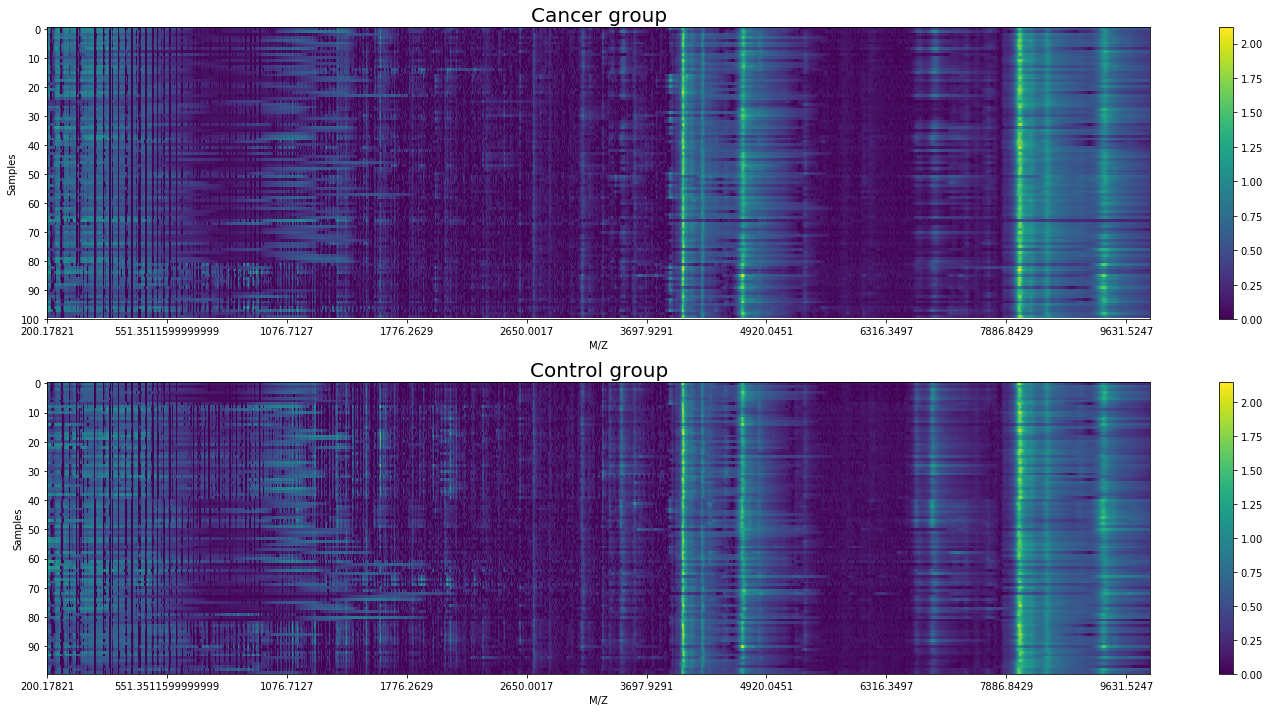

In [19]:
print('Hand Prepared Ovarian Samples')
print('='*100)
heatmap(cancer_group_hand, control_group_hand)

* Spectra heatmap of prostate samples

Prostate Samples


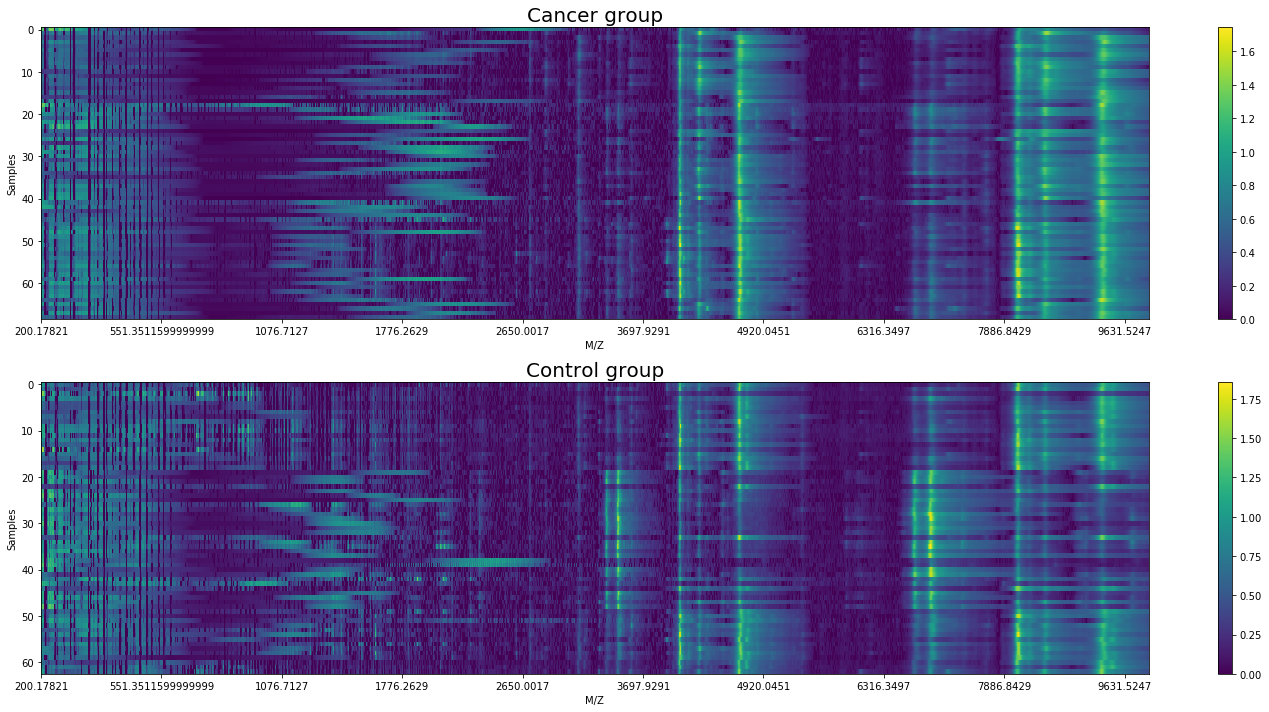

In [20]:
print('Prostate Samples')
print('='*100)
heatmap(cancer_group_prostate, control_group_prostate)

<a id='pca_visualization'></a>
### [2.2 PCA Transformation and Visualization](#TOC)

We are facing a dataset with significantly larger features than samples. This is common for all spectra data, where it is relatively difficult to collect large amount of samples through experiments, but it was fairly easy to obtain tons of features or datapoints through spectroscopy analysis.

Before we do any further analysis, explortary data analysis (EDA) is necessary to evaluate the dataset (e.g., complexicity and data quality). Herein, we would like to visualize the data distribution using the first two principle components.

#### For robotic prepared ovarian samples
The first two components explained almost 60% variance of data, and the first 20 components explained almost 95% variance of data. From the scatterplot of the first two principle components, cancer and non-cancer samples could be reasonably separated

#### For hand prepared ovarian samples
The first two components explained only 30% variance of data, and the first 89 components were needed to explained 95% variance of data. Using only the first two principle components, cancer and non-cancer samples are largely overlaped and cannot be reasonably separated

#### For prostate samples
The first two principle components explained 45% variance of data, and it needs the 44 components to explain 95% variance. Cancer and non-cancer samples could be well separated using the first two principle components


In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca_hand = PCA()
pca_prostate = PCA()

In [22]:
# Transform data and save to pickle files
ovarian_data_transform = pca.fit_transform(ovarian_data)
with open('pickle/pca_ovarian_robotic.pickle', 'wb') as f:
    pickle.dump(pca, f)
    
ovarian_data_hand_transform = pca_hand.fit_transform(ovarian_data_hand)
with open('pickle/pca_ovarian_hand.pickle', 'wb') as f:
    pickle.dump(pca_hand, f)
    
prostate_data_transform = pca_prostate.fit_transform(prostate_data)
with open('pickle/pca_prostate.pickle', 'wb') as f:
    pickle.dump(pca_prostate, f)

with open('pickle/ovarian_robotic_transformed_x_y.pickle', 'wb') as f:
    pickle.dump([ovarian_data_transform, ovarian_label], f)

with open('pickle/ovarian_hand_transformed_x_y.pickle', 'wb') as f:
    pickle.dump([ovarian_data_hand_transform, ovarian_label_hand], f)

with open('pickle/prostate_transformed_x_y.pickle', 'wb') as f:
    pickle.dump([prostate_data_transform, prostate_label], f)


Variance explained ratio of ovarian and prostate samples

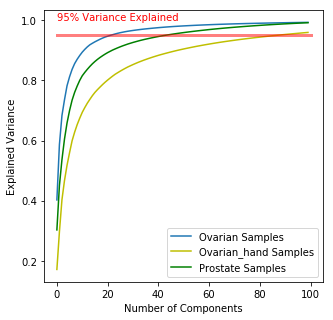

In [23]:
# Show the cumulative explained variance
plt.figure(figsize=[5,5])
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100], label= 'Ovarian Samples')
plt.plot(np.cumsum(pca_hand.explained_variance_ratio_)[:100], 'y', label= 'Ovarian_hand Samples')
plt.plot(np.cumsum(pca_prostate.explained_variance_ratio_)[:100], 'g', label= 'Prostate Samples')

plt.plot([0,100], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.legend(loc = 'best')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

Comparison of cancer classification using first two principle components of robotic prepared ovarian samples, hand prepared ovarian samples and prostate samples. It is noted that cancer/non-cancer in both robotic prepared samples and prostate samples are easily separable, but cancer and non-cancer groups are largely overlapped in hand prepared samples.

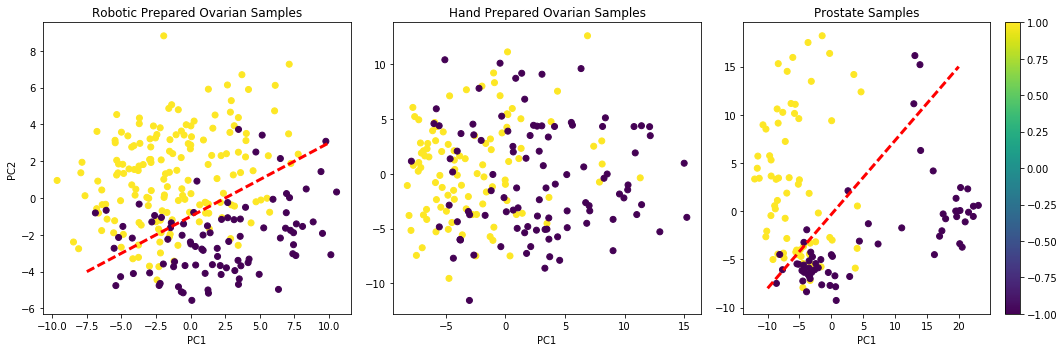

In [24]:
# Scatter plot of PC1 and PC2
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.title('Robotic Prepared Ovarian Samples')
plt.scatter(ovarian_data_transform[:,0], ovarian_data_transform[:,1], c=ovarian_label)
plt.plot([-7.5,10],[-4, 3],'r--',linewidth = 3)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,3,2)
plt.title('Hand Prepared Ovarian Samples')
plt.scatter(ovarian_data_hand_transform[:,0], ovarian_data_hand_transform[:,1], c=ovarian_label_hand)
plt.xlabel('PC1')

plt.subplot(1,3,3)
plt.title('Prostate Samples')
plt.scatter(prostate_data_transform[:,0], prostate_data_transform[:,1], c=prostate_label)
plt.plot([-10,20],[-8, 15],'r--',linewidth = 3)
plt.xlabel('PC1')
plt.colorbar()

plt.tight_layout()


<a id='ml'></a>
# [3. Deep Analysis using Machine Learning Algorithm](#TOC)

Support vector machine was often used in classification of spectra data, because it has strong capacity in handling high-dimension data. Herein, we started with SVM as the benchmark classification method for modeling and predicting cancer

In [25]:
# Define methods for generate performance report of model
def report(model, y, predict):
    print('Report of ' + model)
    print('=================================================================================')
    print('Accuracy of the model:{}'.format(accuracy_score(y, predict)))
    print('AUC score:            {}'.format(roc_auc_score(y, predict)))
    print('F1 score:             {}'.format(f1_score(y, predict)))
    print('Confusion Matrix:')
    print(ConfusionMatrix(y, predict))

<a id='feature_selection'></a>
### [3.1 Feature Selection using Random Forest](#TOC)

Decision Tree is a natural way of feature selection. Tree split is based on maximum gain of gini impurity, so tree always splits towards more important features. Random forest algorithom is ensemble method using tree bagging and random feature selection for each split. Herein, we used Random Forest to select the most important features. We set the thresold at 95%, meaning we expect the most important features could explain more than 95% variance of dataset

In [26]:
# Import random forest from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [27]:
# Select number of features (from high importance to low importance) with total importance more than 95%
def feature_number(feature_importance):
    feature_importance_sort = np.sort(feature_importance)[::-1]
    sums = 0
    for i, j in enumerate(feature_importance_sort):
        sums += j
        if sums>0.95:
            return(i+1)

#### Fit ovarian and prostate data using random forest

In [28]:
# Fit the model using Random Forest
rf_ovarian = RandomForestClassifier(random_state=4)
rf_prostate = RandomForestClassifier(random_state=5)
rf_ovarian_hand = RandomForestClassifier(random_state=6)

rf_ovarian.fit(ovarian_data, ovarian_label)
rf_prostate.fit(prostate_data, prostate_label)
rf_ovarian_hand.fit(ovarian_data_hand, ovarian_label_hand)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=6,
            verbose=0, warm_start=False)

#### Plot the cumulative explained variance of features

It is noted that within 9200 features(M/Z), using only 40 features(0.43% of total features) can explain more than 95% variance for prostate samples, 52 features (0.58% of total features) will explain more than 95% variance for robotic prepared ovarian samples and 86 features (0.93% of total features) is needed for hand prepared ovarian samples. Feature selection will significantly reduce the noisy and redundant features

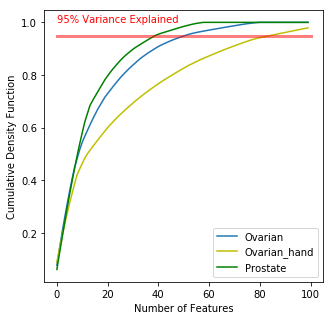

In [29]:
# Plot the cumulative explained variance of features
feature_importance_ovarian = rf_ovarian.feature_importances_
feature_importance_prostate = rf_prostate.feature_importances_
feature_importance_ovarian_hand = rf_ovarian_hand.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_ovarian)[::-1][:100]), label = 'Ovarian')
plt.plot(np.cumsum(np.sort(feature_importance_ovarian_hand)[::-1][:100]), 'y', label ='Ovarian_hand')
plt.plot(np.cumsum(np.sort(feature_importance_prostate)[::-1][:100]), 'g', label ='Prostate')


plt.plot([0,100], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')
plt.legend(loc='best')

In [30]:
# Select indexes of top features explaining 95% of variance
important_feature_index_ovarian = np.argsort(feature_importance_ovarian)[::-1][:(feature_number(feature_importance_ovarian))]
important_feature_index_prostate = np.argsort(feature_importance_prostate)[::-1][:(feature_number(feature_importance_prostate))]
important_feature_index_ovarian_hand = np.argsort(feature_importance_ovarian_hand)[::-1][:(feature_number(feature_importance_ovarian_hand))]

In [31]:
# Write important feature index to pickle files
for i,j in zip(
    ['pickle/feature_index_ovarian.pickle','pickle/feature_index_ovarian_hand.pickle','pickle/feature_index_prostate.pickle'],
    [important_feature_index_ovarian, important_feature_index_ovarian_hand, important_feature_index_prostate]):    
    
    with open(i, 'wb') as f:
        pickle.dump(j, f)
    

<a id='models'></a>
### [3.2 Modeling using different algorithm (SVM, Random Forest, and KNN)](#TOC)

In [32]:
# Split the data to training and testing data
from sklearn.model_selection import train_test_split

x_train_ovarian, x_test_ovarian, y_train_ovarian, y_test_ovarian = train_test_split(ovarian_data.iloc[:,important_feature_index_ovarian], 
                                                                                    ovarian_label,
                                                                                    test_size = 0.3, 
                                                                                    random_state = 10)

x_train_prostate, x_test_prostate, y_train_prostate, y_test_prostate = train_test_split(prostate_data.iloc[:,important_feature_index_prostate], 
                                                                                    prostate_label,
                                                                                    test_size = 0.3, 
                                                                                    random_state = 10)

x_train_ovarian_hand, x_test_ovarian_hand, y_train_ovarian_hand, y_test_ovarian_hand = train_test_split(ovarian_data_hand.iloc[:,important_feature_index_ovarian_hand], 
                                                                                    ovarian_label_hand,
                                                                                    test_size = 0.3, 
                                                                                    random_state = 10)

#### SVM

In [33]:
# Import necessary sklearn package for ML
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from pandas_ml import ConfusionMatrix 

# make pipeline using standard scale and svc
pipeline=make_pipeline(StandardScaler(), SVC(probability=True))
param_grid = {'svc__C': 10.**np.arange(-3,3), 'svc__gamma': 10.**np.arange(-3,3)}

# Create gridsearch object to tune C and gammas values
gs = GridSearchCV(pipeline, param_grid=param_grid)

# Fit data and predict testing results
gs.fit(x_train_ovarian, y_train_ovarian)

clf_svm_ovarian = gs.best_estimator_

with open('pickle/svc_ovarian_robotic.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)

    
svc_predict_ovarian = gs.predict(x_test_ovarian)
svc_predict_proba_ovarian = gs.predict_proba(x_test_ovarian)

# Ovarian_hand data fit and predict
gs.fit(x_train_ovarian_hand, y_train_ovarian_hand)
clf_svm_ovarian_hand = gs.best_estimator_

with open('pickle/svc_ovarian_hand.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
svc_predict_ovarian_hand = gs.predict(x_test_ovarian_hand)

# Prostate data fit and predict
gs.fit(x_train_prostate, y_train_prostate)
clf_svm_prostate = gs.best_estimator_

with open('pickle/svc_prostate.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
svc_predict_prostate = gs.predict(x_test_prostate)



In [34]:
# Generate performance report
report('SVM with selected features for ovarian prediction', y_test_ovarian, svc_predict_ovarian)
print('\n')
print('='*100)
report('SVM with selected features for ovarian hand prediction', y_test_ovarian_hand, svc_predict_ovarian_hand)
print('\n')
print('='*100)
print('\n')
report('SVM with selected features for prostate prediction', y_test_prostate, svc_predict_prostate)

Report of SVM with selected features for ovarian prediction
Accuracy of the model:1.0
AUC score:            1.0
F1 score:             1.0
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         27   0       27
1           0  49       49
__all__    27  49       76


Report of SVM with selected features for ovarian hand prediction
Accuracy of the model:0.95
AUC score:            0.9423076923076923
F1 score:             0.9577464788732395
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         23   3       26
1           0  34       34
__all__    23  37       60




Report of SVM with selected features for prostate prediction
Accuracy of the model:0.975
AUC score:            0.9705882352941176
F1 score:             0.9787234042553191
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         16   1       17
1           0  23       23
__all__    16  24       40


#### Random Forest

In [35]:
# Tune parameters for random forest, using n_estimators and max_features to tune

param_grid = {'n_estimators': 10**np.arange(3), 
              'max_features': ['auto','sqrt','log2']}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs.fit(x_train_ovarian, y_train_ovarian)
clf_rf_ovarian = gs.best_estimator_

with open('pickle/rf_ovarian_robotic.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
rf_predict_ovarian = gs.predict(x_test_ovarian)
rf_predict_proba_ovarian = gs.predict_proba(x_test_ovarian)

# Fit and predict ovarian hand data
gs.fit(x_train_ovarian_hand, y_train_ovarian_hand)
clf_rf_ovarian_hand = gs.best_estimator_

with open('pickle/rf_ovarian_hand.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
rf_predict_ovarian_hand = gs.predict(x_test_ovarian_hand)

# Fit and predict prostate data
gs.fit(x_train_prostate, y_train_prostate)
clf_rf_prostate = gs.best_estimator_

with open('pickle/rf_prostate.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
rf_predict_prostate = gs.predict(x_test_prostate)

In [36]:
report('Random Forest with selected features for ovarian prediction', y_test_ovarian, rf_predict_ovarian)
print('\n')
print('='*100)
report('Random Forest with selected features for ovarian hand prediction', y_test_ovarian_hand, rf_predict_ovarian_hand)
print('\n')
print('='*100)
print('\n')
report('Random Forest with selected features for prostate prediction', y_test_prostate, rf_predict_prostate)

Report of Random Forest with selected features for ovarian prediction
Accuracy of the model:0.9868421052631579
AUC score:            0.9897959183673469
F1 score:             0.9896907216494846
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         27   0       27
1           1  48       49
__all__    28  48       76


Report of Random Forest with selected features for ovarian hand prediction
Accuracy of the model:0.95
AUC score:            0.9423076923076923
F1 score:             0.9577464788732395
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         23   3       26
1           0  34       34
__all__    23  37       60




Report of Random Forest with selected features for prostate prediction
Accuracy of the model:0.925
AUC score:            0.9347826086956521
F1 score:             0.9302325581395349
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         17   0       17
1           3  20       23
__al

#### KNN

In [37]:
# Tune parameters for random forest, using n_neighbors to tune

from sklearn.neighbors import KNeighborsClassifier
param_grid_knn = {'n_neighbors':np.arange(1,30)}
gs = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)

# Fit and predict ovarian
gs.fit(x_train_ovarian, y_train_ovarian)
clf_knn_ovarian = gs.best_estimator_

with open('pickle/knn_ovarian_robotic.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
knn_predict_ovarian = gs.predict(x_test_ovarian)

# Fit and predict ovarian
gs.fit(x_train_ovarian_hand, y_train_ovarian_hand)
clf_knn_ovarian_hand = gs.best_estimator_

with open('pickle/knn_ovarian_hand.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
knn_predict_ovarian_hand = gs.predict(x_test_ovarian_hand)

# Fit and predict prostate
gs.fit(x_train_prostate, y_train_prostate)
clf_knn_prostate = gs.best_estimator_

with open('pickle/knn_prostate.pickle', 'wb') as f:
    pickle.dump(gs.best_estimator_, f)
    
knn_predict_prostate = gs.predict(x_test_prostate)
knn_predict_proba_prostate = gs.predict_proba(x_test_prostate)

In [38]:
# Generate knn performance report for ovarian and prostate data

report('knn ovarian', y_test_ovarian, knn_predict_ovarian)
print('\n')
print('='*100)
report('knn ovarian hand', y_test_ovarian_hand, knn_predict_ovarian_hand)
print('\n')
print('='*100)
print('\n')
report('knn prostate', y_test_prostate, knn_predict_prostate)

Report of knn ovarian
Accuracy of the model:0.9868421052631579
AUC score:            0.9897959183673469
F1 score:             0.9896907216494846
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         27   0       27
1           1  48       49
__all__    28  48       76


Report of knn ovarian hand
Accuracy of the model:0.9333333333333333
AUC score:            0.9276018099547512
F1 score:             0.9428571428571428
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         23   3       26
1           1  33       34
__all__    24  36       60




Report of knn prostate
Accuracy of the model:0.95
AUC score:            0.948849104859335
F1 score:             0.9565217391304348
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         16   1       17
1           1  22       23
__all__    17  23       40


<a id='performance'></a>
### [3.3 Comparison of model performance of SVM, Random Forest, and KNN](#TOC)
It is noticed that for the prediction of both ovarian and prostate cancers, all ML models performs well. For robotic prepared ovarian data, Random Forest and SVM can achieve 100% accuracy. For hand prepared ovarian data, SVM performs best and achieved 95% accuracy. Meanwhile, for prostate data, knn can achieve 100% accuracy. However, we should not be too confident on our models, because we will need much larger data to optimize our models and test the model performance. Our models also have to be flexible, meaning it can deal with situations where more noise than usual appears in the mass spectrum (e.g., the impurities in the samples during sample preparation and instruments errors)

In [39]:
comparison = pd.DataFrame({'SVM':[accuracy_score(y_test_ovarian, svc_predict_ovarian), 
                                  roc_auc_score(y_test_ovarian, svc_predict_ovarian), 
                                  f1_score(y_test_ovarian, svc_predict_ovarian), 
                                  accuracy_score(y_test_ovarian_hand, svc_predict_ovarian_hand),  
                                  roc_auc_score(y_test_ovarian_hand, svc_predict_ovarian_hand), 
                                  f1_score(y_test_ovarian_hand, svc_predict_ovarian_hand), 
                                  accuracy_score(y_test_prostate, svc_predict_prostate), 
                                  roc_auc_score(y_test_prostate, svc_predict_prostate),
                                  f1_score(y_test_prostate, svc_predict_prostate)], 
                           'Random Forest':[accuracy_score(y_test_ovarian, rf_predict_ovarian), 
                                            roc_auc_score(y_test_ovarian, rf_predict_ovarian),
                                            f1_score(y_test_ovarian, rf_predict_ovarian),
                                            accuracy_score(y_test_ovarian_hand, rf_predict_ovarian_hand), 
                                            roc_auc_score(y_test_ovarian_hand, rf_predict_ovarian_hand),
                                            f1_score(y_test_ovarian_hand, rf_predict_ovarian_hand),
                                            accuracy_score(y_test_prostate, svc_predict_prostate), 
                                            roc_auc_score(y_test_prostate, svc_predict_prostate),
                                            f1_score(y_test_prostate, svc_predict_prostate)], 
                           'KNN':[accuracy_score(y_test_ovarian, knn_predict_ovarian),
                                  roc_auc_score(y_test_ovarian, knn_predict_ovarian),
                                  f1_score(y_test_ovarian, knn_predict_ovarian), 
                                  accuracy_score(y_test_ovarian_hand, knn_predict_ovarian_hand), 
                                  roc_auc_score(y_test_ovarian_hand, knn_predict_ovarian_hand),
                                  f1_score(y_test_ovarian_hand, knn_predict_ovarian_hand), 
                                  accuracy_score(y_test_prostate, knn_predict_prostate),
                                  roc_auc_score(y_test_prostate, knn_predict_prostate),
                                  f1_score(y_test_prostate, knn_predict_prostate)],
                           'Score': ['Accuracy', 'AUC', 'F1-Score','Accuracy', 'AUC', 'F1-Score','Accuracy', 'AUC', 'F1-Score'],
                           'Data':  np.repeat(['Ovarian','Ovarian hand', 'Prostate'],[3,3,3])}).set_index(['Data','Score'])
print(comparison)

                            KNN  Random Forest       SVM
Data         Score                                      
Ovarian      Accuracy  0.986842       0.986842  1.000000
             AUC       0.989796       0.989796  1.000000
             F1-Score  0.989691       0.989691  1.000000
Ovarian hand Accuracy  0.933333       0.950000  0.950000
             AUC       0.927602       0.942308  0.942308
             F1-Score  0.942857       0.957746  0.957746
Prostate     Accuracy  0.950000       0.975000  0.975000
             AUC       0.948849       0.970588  0.970588
             F1-Score  0.956522       0.978723  0.978723


** Which model to choose for robotic ovarian dataset? **

For robotic ovarian prediction, both Random forest and SVM produce almost 100% accuracy of prediction cancer and non-cancer group, so which model to choose? In theory, we would like to choose a model that could provide more extreme probability

It is noted that SVM will provide more extreme probability than random forest due to the fact the ovarian cancer and non-cancer group could be separated by hyperplane. So using SVM for prediction will provide better solutions.

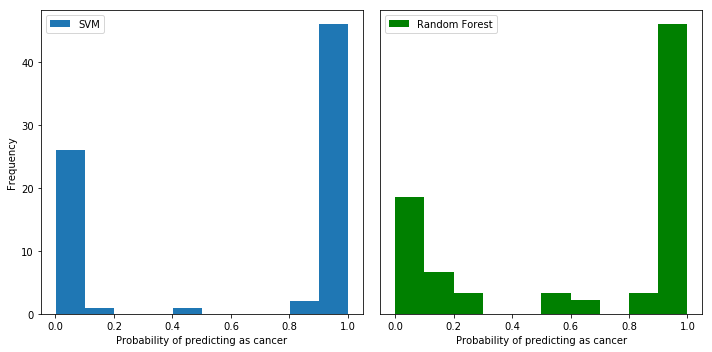

In [40]:
# Plot the histogram for probability distribution of cancer predicting
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(svc_predict_proba_ovarian[:,1], label='SVM')
plt.ylabel('Frequency')
plt.xlabel('Probability of predicting as cancer')
plt.legend(loc = 'best')

# Plot the histogram for probability distribution of predicting female
plt.subplot(1,2,2)
plt.hist(rf_predict_proba_ovarian[:,1], label='Random Forest', color = 'g')
plt.xlabel('Probability of predicting as cancer')
plt.yticks([])
plt.legend(loc = 'best')

plt.tight_layout()

<a id = 'extendedquestions'></a>
# [4. Extended Questions](#TOC)

<a id = 'ensemble'></a>
### [4.1 Can ensemble model increase the performance of prediction?](#TOC)
Herein, we are interested to know whether ensembled model by voting could improve the performance of prediction. For robotic prepared ovarian cancer prediction, ensemble model showed a 99% accuracy similar as SVM. Interestingly, in hand prepared ovarian and prostate samples, although single model performs similarly as ensemble model in terms of prediction accuracy, we could see the ensemble model has a lower rate of false positive rate, which is what we were targeting for in cancer diagonsis. So, we will choose ensemble model over others to predict ovarian and prostate cancer.

In [41]:
from sklearn.ensemble import VotingClassifier

#### For robotic prepared ovarian samples

In [42]:
# We used svc, rf and knn together to predict cancer
eclf = VotingClassifier(estimators=[('svc', clf_svm_ovarian), ('rf', clf_rf_ovarian), ('knn', clf_knn_ovarian)], voting='soft')
eclf.fit(x_train_ovarian, y_train_ovarian)
with open('pickle/ensemble_ovarian_robotic.pickle', 'wb') as f:
    pickle.dump(eclf, f)
    
eclf_predict = eclf.predict(x_test_ovarian)

In [43]:
report('Ensemble model performance on robotic prepared samples', y_test_ovarian, eclf_predict)

Report of Ensemble model performance on robotic prepared samples
Accuracy of the model:0.9868421052631579
AUC score:            0.9897959183673469
F1 score:             0.9896907216494846
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         27   0       27
1           1  48       49
__all__    28  48       76


In [44]:
scores_robotic = [accuracy_score(y_test_ovarian, i) for i in [svc_predict_ovarian, rf_predict_ovarian, knn_predict_ovarian, eclf_predict]]

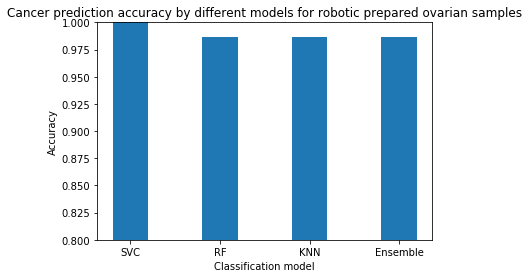

In [45]:
plt.bar(np.arange(4), scores_robotic, width=0.4)
plt.title('Cancer prediction accuracy by different models for robotic prepared ovarian samples')
plt.xticks(np.arange(4), ['SVC','RF', 'KNN', 'Ensemble'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Classification model')

#### For hand prepared ovarian samples 

In [46]:
# We used svc, rf and knn together to predict cancer
eclf = VotingClassifier(estimators=[('svc', clf_svm_ovarian_hand), ('rf', clf_rf_ovarian_hand), ('knn', clf_knn_ovarian_hand)], voting='soft')
eclf.fit(x_train_ovarian_hand, y_train_ovarian_hand)
with open('pickle/ensemble_ovarian_hand.pickle', 'wb') as f:
    pickle.dump(eclf, f)
    
eclf_hand_predict = eclf.predict(x_test_ovarian_hand)

In [47]:
report('Ensemble model performance on hand prepared samples', eclf_hand_predict, y_test_ovarian_hand)

Report of Ensemble model performance on hand prepared samples
Accuracy of the model:0.95
AUC score:            0.9594594594594594
F1 score:             0.9577464788732395
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         23   0       23
1           3  34       37
__all__    26  34       60


In [48]:
scores_hand = [accuracy_score(y_test_ovarian_hand, i) for i in [svc_predict_ovarian_hand, rf_predict_ovarian_hand, knn_predict_ovarian_hand, eclf_hand_predict]]

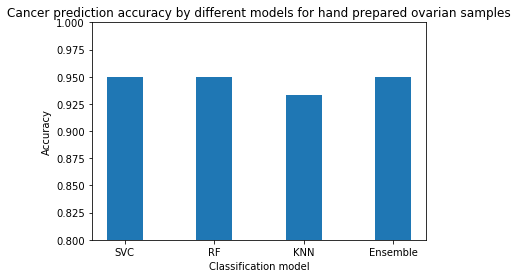

In [49]:
plt.bar(np.arange(4), scores_hand, width=0.4)
plt.title('Cancer prediction accuracy by different models for hand prepared ovarian samples')
plt.xticks(np.arange(4), ['SVC','RF', 'KNN', 'Ensemble'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Classification model')

#### For prostate samples 

In [50]:
eclf = VotingClassifier(estimators=[('svc', clf_svm_prostate), ('rf', clf_rf_prostate), ('knn', clf_knn_prostate)], voting='soft')
eclf.fit(x_train_prostate, y_train_prostate)
with open('pickle/ensemble_prostate.pickle', 'wb') as f:
    pickle.dump(eclf, f)
    
eclf_prostate_predict = eclf.predict(x_test_prostate)

In [51]:
report('Ensemble model performance on prostate samples', eclf_prostate_predict, y_test_prostate)

Report of Ensemble model performance on prostate samples
Accuracy of the model:0.975
AUC score:            0.9791666666666667
F1 score:             0.9787234042553191
Confusion Matrix:
Predicted  -1   1  __all__
Actual                    
-1         16   0       16
1           1  23       24
__all__    17  23       40


In [52]:
scores_prostate = [accuracy_score(y_test_prostate, i) for i in [svc_predict_prostate, rf_predict_prostate, knn_predict_prostate, eclf_prostate_predict]]

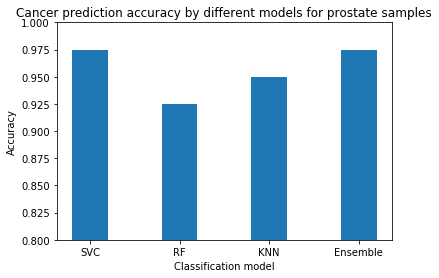

In [53]:
plt.bar(np.arange(4), scores_prostate, width=0.4)
plt.title('Cancer prediction accuracy by different models for prostate samples')
plt.xticks(np.arange(4), ['SVC','RF', 'KNN', 'Ensemble'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Classification model')

<a id = 'aliensample'></a>
### [4.2 Can you tell if a new sample could be used for cancer prediction using your model?](#TOC)

Problem explained in ML: Find whether the new sample belongs to any existing trained group using PCA.

#### 1. Plotting the first two priciple components obtained by PCA fit_transform

There are six labels for all group in this study. Let's assign 1 for robotic prepared ovarian cancer, 2 for robotic prepared ovarian control, 3 for hand prepared ovarian cancer, 4 for hand prepared ovarian control, 5 for prostate cancer, 6 for prostate control

In [54]:
xdata = pd.concat([cancer_group, control_group, cancer_group_hand, control_group_hand, cancer_group_prostate, control_group_prostate], ignore_index=True)

# Get the length of inidividual dataset
len_list = list(map(lambda x: len(x), [cancer_group, control_group, cancer_group_hand, control_group_hand, cancer_group_prostate, control_group_prostate]))

# Creat labels for xdata
ylabels = np.repeat([1,2,3,4,5,6], len_list)
ylabels_original = ylabels

# Fit xdata using PCA
pca = PCA(n_components=2)

# Transform data
xdata_transform = pca.fit_transform(xdata)

with open('pickle/whole_data_multiclass.pickle', 'wb') as f:
    pickle.dump([xdata_transform, ylabels], f)

with open('pickle/pca_whole_data.pickle', 'wb') as f:
    pickle.dump(pca, f)

#### 2. PCA for visualization

It is easily seen that using the first two principle components, we can easily separate robotic prepared ovarian samples and prostate samples, but hand-prepared ovarian samples were overlapped with prostate samples. If given new samples (herein we use df_transform data prepared in section 1.1 as an example), we can pinpoint this point in the figure to provide an intuitive visualization of whether this datapoint is associated with any training group so that we can apply our model for prediction.<br><br>
In this case, the new sample(indicated by red bubble) belongs to our training group, so we can use this new sample for cancer prediction.

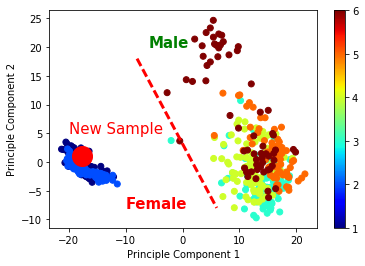

In [55]:
# Transfrom df_transform using pca
df_transform_pca = pca.transform(df_transform)


# Scatter plot using the first two principle components
plt.scatter(xdata_transform[:,0],xdata_transform[:,1], c = ylabels, cmap='jet')
plt.plot([-8,6],[18,-8], 'r--', linewidth = 3)
plt.annotate('Female',xy = [-10,-8], fontsize = 15, fontweight = 'bold', color = 'r')
plt.annotate('Male', xy = [-6,20], fontsize = 15, fontweight = 'bold', color = 'g')
plt.plot(df_transform_pca[:,0], df_transform_pca[:,1], color = 'red', marker= 'o', markersize = 20)
plt.annotate('New Sample', xy = [-20, 5], color = 'red', fontsize = 15)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar()

<a id = 'mixup'></a>
### [4.3 If samples were accidentally mixed up, can you tell which group it belongs to?](#TOC)

Herein, we demonstrated how to assign these data into individual 6 groups, robotic prepared/hand prepared groups and male/female groups, respectively.

### 4.3.1 Seperation by 6 individual groups
There are six labels for all group in this study, 1 for robotic prepared ovarian cancer, 2 for robotic prepared ovarian control, 3 for hand prepared ovarian cancer, 4 for hand prepared ovarian control, 5 for prostate cancer, 6 for prostate control. We have to decide which group the sample belongs to using multiclassification. It turns out SVM can efficiently separate six groups, with up to 93% accuracy.

#### Feature Selection using Random Forest 
It is noted that within 9200 features (M/Z), using 245 features can explain more than 95% variance. Feature selection will significantly reduce the noise features

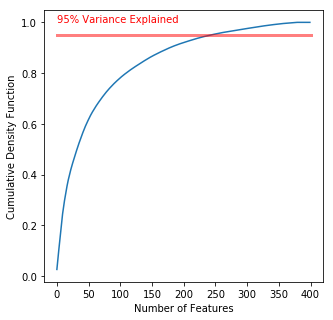

In [56]:
# Fit the model using Random Forest
rf_xdata = RandomForestClassifier(random_state=4)
rf_xdata.fit(xdata, ylabels)

# Plot the cumulative explained variance of features
feature_importance_xdata = rf_xdata.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_xdata)[::-1][:400]))

plt.plot([0,400], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')

# Select indexes of top features explaining 95% of variance
important_feature_index_xdata = np.argsort(feature_importance_xdata)[::-1][:(feature_number(feature_importance_xdata))]

with open('pickle/important_features_multiclass.pickle', 'wb') as f:
    pickle.dump(important_feature_index_xdata, f)
    
# Select important features and split data into training and testing set
xtrain_multiclass, xtest_multiclass, ytrain_multiclass, ytest_multiclass = train_test_split(xdata.iloc[:,important_feature_index_xdata], 
                                                                                            ylabels, 
                                                                                            test_size = 0.3, 
                                                                                            random_state = 1)

#### Modeling using different algorithm (SVM, Random Forest, and KNN)

- SVM

In [57]:
# make pipeline using standard scale and svc
pipeline=make_pipeline(StandardScaler(), SVC(probability=True))
param_grid = {'svc__C': 10.**np.arange(-3,3), 'svc__gamma': 10.**np.arange(-4,3)}

# Create gridsearch object to tune C and gammas values
gs_svm = GridSearchCV(pipeline, param_grid=param_grid)

# Fit data and predict testing results
gs_svm.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/svc_predict_multiclass.pickle', 'wb') as f:
    pickle.dump(gs_svm.best_estimator_, f)
    
svc_predict_multiclass = gs_svm.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by SVM is {:.2f}'.format(accuracy_score(ytest_multiclass,svc_predict_multiclass)))
print('\n')
print('The confusion matrix by SVM is: \n{}'.format(confusion_matrix(ytest_multiclass, svc_predict_multiclass)))
print('The best parameter of SVM is: {}'.format(gs_svm.best_params_))

The prediction accuracy by SVM is 0.93


The confusion matrix by SVM is: 
[[49  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0 21  0  0  3]
 [ 0  0  4 34  2  0]
 [ 0  0  2  0 23  0]
 [ 0  0  0  0  1 16]]
The best parameter of SVM is: {'svc__C': 100.0, 'svc__gamma': 0.001}


- KNN

In [58]:
# Tune parameters for knn, using n_neighbors to tune
param_grid_knn = {'n_neighbors':np.arange(1,30)}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)

# Fit and predict
gs_knn.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/knn_predict_multiclass.pickle', 'wb') as f:
    pickle.dump(gs_knn.best_estimator_, f)
    
knn_predict_multiclass = gs_knn.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by KNN is {:.2f}'.format(accuracy_score(ytest_multiclass,knn_predict_multiclass)))
print('\n')
print('The confusion matrix by KNN is: \n{}'.format(confusion_matrix(ytest_multiclass, knn_predict_multiclass)))
print('The best parameter of KNN is: {}'.format(gs_knn.best_params_))

The prediction accuracy by KNN is 0.90


The confusion matrix by KNN is: 
[[49  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0 16  3  4  1]
 [ 0  0  3 35  2  0]
 [ 0  0  2  0 23  0]
 [ 0  0  1  0  1 15]]
The best parameter of KNN is: {'n_neighbors': 1}


- Random Forest

In [59]:
# Tune parameters for random forest, using n_estimators and max_features to tune
param_grid = {'n_estimators': 10**np.arange(3), 
              'max_features': ['auto','sqrt','log2']}
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs_rf.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/rf_predict_multiclass.pickle', 'wb') as f:
    pickle.dump(gs_rf.best_estimator_, f)
rf_predict_multiclass = gs_rf.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,rf_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, rf_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(gs_rf.best_params_))

The prediction accuracy by Random Forest is 0.87


The confusion matrix by Random Forest is: 
[[49  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0 19  2  1  2]
 [ 0  0  6 32  2  0]
 [ 0  0  5  0 19  1]
 [ 0  0  1  2  1 13]]
The best parameter of Random Forest is: {'max_features': 'log2', 'n_estimators': 100}


- Ensemble Method

In [60]:
ensemble_multiclass = VotingClassifier(estimators=[('svc', gs_svm),('knn', gs_knn), ('rf', gs_rf)], voting='soft')

In [61]:
ensemble_multiclass.fit(xtrain_multiclass, ytrain_multiclass)
with open('pickle/ensemble_predict_multiclass.pickle', 'wb') as f:
    pickle.dump(ensemble_multiclass, f)

ensemble_predict_multiclass = ensemble_multiclass.predict(xtest_multiclass)
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,ensemble_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, ensemble_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(ensemble_multiclass.get_params))

The prediction accuracy by Random Forest is 0.93


The confusion matrix by Random Forest is: 
[[49  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0 20  2  1  1]
 [ 0  0  3 35  2  0]
 [ 0  0  2  0 23  0]
 [ 0  0  1  0  1 15]]
The best parameter of Random Forest is: <bound method VotingClassifier.get_params of VotingClassifier(estimators=[('svc', GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kerne...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))],
         n_jobs=1, voting='soft', weights=None)>


### 4.3.2 Seperation by robotic prepared and hand prepared groups
There are two labels for all groups in this study, 1 for robotic prepared samples, 2 for hand prepared samples. It turns out all models, including SVM, Random Forest and KNN, can efficiently separate samples to these two groups, with up to 100% accuracy.

#### Feature Selection using Random Forest 
It is noted that within 9200 features (M/Z), using 10 features can explain more than 95% variance. Feature selection will significantly reduce the noise features

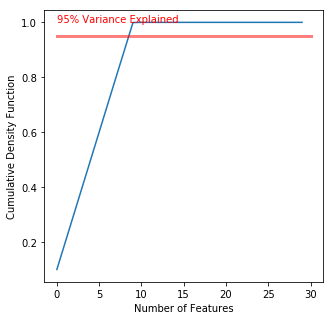

In [62]:
# Get the length of inidividual dataset
len_list = list(map(lambda x: len(x), [cancer_group, control_group, cancer_group_hand, control_group_hand, cancer_group_prostate, control_group_prostate]))

# Creat labels for xdata
ylabels = np.repeat([1,1,2,2,2,2], len_list)

# Fit the model using Random Forest
rf_xdata = RandomForestClassifier(random_state=4)
rf_xdata.fit(xdata, ylabels)

# Plot the cumulative explained variance of features
feature_importance_xdata = rf_xdata.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_xdata)[::-1][:30]))

plt.plot([0,30], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')

# Select indexes of top features explaining 95% of variance
important_feature_index_xdata = np.argsort(feature_importance_xdata)[::-1][:(feature_number(feature_importance_xdata))]

with open('pickle/important_features_robotic_hand.pickle', 'wb') as f:
    pickle.dump(important_feature_index_xdata, f)
    
# Select important features and split data into training and testing set
xtrain_multiclass, xtest_multiclass, ytrain_multiclass, ytest_multiclass = train_test_split(xdata.iloc[:,important_feature_index_xdata], 
                                                                                            ylabels, 
                                                                                            test_size = 0.3, 
                                                                                            random_state = 1)

#### Modeling using different algorithm (SVM, Random Forest, and KNN)

- SVM

In [63]:
# make pipeline using standard scale and svc
pipeline=make_pipeline(StandardScaler(), SVC(probability=True))
param_grid = {'svc__C': 10.**np.arange(-3,3), 'svc__gamma': 10.**np.arange(-4,3)}

# Create gridsearch object to tune C and gammas values
gs_svm = GridSearchCV(pipeline, param_grid=param_grid)

# Fit data and predict testing results
gs_svm.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/svc_predict_robotic_hand.pickle', 'wb') as f:
    pickle.dump(gs_svm.best_estimator_, f)
    
svc_predict_multiclass = gs_svm.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by SVM is {:.2f}'.format(accuracy_score(ytest_multiclass,svc_predict_multiclass)))
print('\n')
print('The confusion matrix by SVM is: \n{}'.format(confusion_matrix(ytest_multiclass, svc_predict_multiclass)))
print('The best parameter of SVM is: {}'.format(gs_svm.best_params_))

The prediction accuracy by SVM is 1.00


The confusion matrix by SVM is: 
[[ 70   0]
 [  0 106]]
The best parameter of SVM is: {'svc__C': 0.01, 'svc__gamma': 0.10000000000000001}


- KNN

In [64]:
# Tune parameters for knn, using n_neighbors to tune
param_grid_knn = {'n_neighbors':np.arange(1,30)}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)

# Fit and predict
gs_knn.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/knn_predict_robotic_hand.pickle', 'wb') as f:
    pickle.dump(gs_knn.best_estimator_, f)
    
knn_predict_multiclass = gs_knn.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by KNN is {:.2f}'.format(accuracy_score(ytest_multiclass,knn_predict_multiclass)))
print('\n')
print('The confusion matrix by KNN is: \n{}'.format(confusion_matrix(ytest_multiclass, knn_predict_multiclass)))
print('The best parameter of KNN is: {}'.format(gs_knn.best_params_))

The prediction accuracy by KNN is 1.00


The confusion matrix by KNN is: 
[[ 70   0]
 [  0 106]]
The best parameter of KNN is: {'n_neighbors': 1}


- Random Forest

In [65]:
# Tune parameters for random forest, using n_estimators and max_features to tune
param_grid = {'n_estimators': 10**np.arange(3), 
              'max_features': ['auto','sqrt','log2']}
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs_rf.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/rf_predict_robotic_hand.pickle', 'wb') as f:
    pickle.dump(gs_rf.best_estimator_, f)
rf_predict_multiclass = gs_rf.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,rf_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, rf_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(gs_rf.best_params_))

The prediction accuracy by Random Forest is 0.99


The confusion matrix by Random Forest is: 
[[ 70   0]
 [  1 105]]
The best parameter of Random Forest is: {'max_features': 'auto', 'n_estimators': 1}


- Ensemble Method

In [66]:
ensemble_multiclass = VotingClassifier(estimators=[('svc', gs_svm),('knn', gs_knn), ('rf', gs_rf)], voting='soft')

In [67]:
ensemble_multiclass.fit(xtrain_multiclass, ytrain_multiclass)
with open('pickle/ensemble_predict_robotic_hand.pickle', 'wb') as f:
    pickle.dump(ensemble_multiclass, f)

ensemble_predict_multiclass = ensemble_multiclass.predict(xtest_multiclass)
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,ensemble_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, ensemble_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(ensemble_multiclass.get_params))

The prediction accuracy by Random Forest is 1.00


The confusion matrix by Random Forest is: 
[[ 70   0]
 [  0 106]]
The best parameter of Random Forest is: <bound method VotingClassifier.get_params of VotingClassifier(estimators=[('svc', GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kerne...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))],
         n_jobs=1, voting='soft', weights=None)>


### 4.3.3 Seperation by sex
There are 2 labels for sex group. 1 for female, 2 for male. It turned out that SVM could provide the highest accuracy of prediction, with 97% accuracy

#### Feature Selection using Random Forest 
It is noted that within 9200 features (M/Z), using 110 features can explain more than 95% variance. Feature selection will significantly reduce the noise features

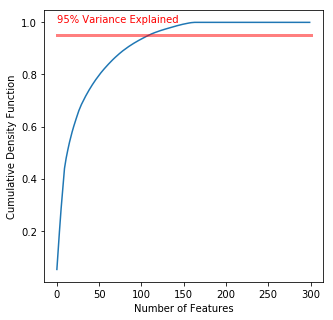

In [68]:
# Get the length of inidividual dataset
len_list = list(map(lambda x: len(x), [cancer_group, control_group, cancer_group_hand, control_group_hand, cancer_group_prostate, control_group_prostate]))

# Creat labels for xdata
ylabels = np.repeat([1,1,1,1,2,2], len_list)

# Fit the model using Random Forest
rf_xdata = RandomForestClassifier(random_state=4)
rf_xdata.fit(xdata, ylabels)

# Plot the cumulative explained variance of features
feature_importance_xdata = rf_xdata.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_xdata)[::-1][:300]))

plt.plot([0,300], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')

# Select indexes of top features explaining 95% of variance
important_feature_index_xdata = np.argsort(feature_importance_xdata)[::-1][:(feature_number(feature_importance_xdata))]

with open('pickle/important_features_sex.pickle', 'wb') as f:
    pickle.dump(important_feature_index_xdata, f)
    
# Select important features and split data into training and testing set
xtrain_multiclass, xtest_multiclass, ytrain_multiclass, ytest_multiclass = train_test_split(xdata.iloc[:,important_feature_index_xdata], 
                                                                                            ylabels, 
                                                                                            test_size = 0.3, 
                                                                                            random_state = 1)

#### Modeling using different algorithm (SVM, Random Forest, and KNN)

- SVM

In [69]:
# make pipeline using standard scale and svc
pipeline=make_pipeline(StandardScaler(), SVC(probability=True))
param_grid = {'svc__C': 10.**np.arange(-3,3), 'svc__gamma': 10.**np.arange(-4,3)}

# Create gridsearch object to tune C and gammas values
gs_svm = GridSearchCV(pipeline, param_grid=param_grid)

# Fit data and predict testing results
gs_svm.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/svc_predict_sex.pickle', 'wb') as f:
    pickle.dump(gs_svm.best_estimator_, f)
    
svc_predict_multiclass = gs_svm.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by SVM is {:.2f}'.format(accuracy_score(ytest_multiclass,svc_predict_multiclass)))
print('\n')
print('The confusion matrix by SVM is: \n{}'.format(confusion_matrix(ytest_multiclass, svc_predict_multiclass)))
print('The best parameter of SVM is: {}'.format(gs_svm.best_params_))

The prediction accuracy by SVM is 0.97


The confusion matrix by SVM is: 
[[130   4]
 [  1  41]]
The best parameter of SVM is: {'svc__C': 10.0, 'svc__gamma': 0.01}


- KNN

In [70]:
# Tune parameters for knn, using n_neighbors to tune
param_grid_knn = {'n_neighbors':np.arange(1,30)}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)

# Fit and predict
gs_knn.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/knn_predict_sex.pickle', 'wb') as f:
    pickle.dump(gs_knn.best_estimator_, f)
    
knn_predict_multiclass = gs_knn.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by KNN is {:.2f}'.format(accuracy_score(ytest_multiclass,knn_predict_multiclass)))
print('\n')
print('The confusion matrix by KNN is: \n{}'.format(confusion_matrix(ytest_multiclass, knn_predict_multiclass)))
print('The best parameter of KNN is: {}'.format(gs_knn.best_params_))

The prediction accuracy by KNN is 0.91


The confusion matrix by KNN is: 
[[125   9]
 [  6  36]]
The best parameter of KNN is: {'n_neighbors': 1}


- Random Forest

In [71]:
# Tune parameters for random forest, using n_estimators and max_features to tune
param_grid = {'n_estimators': 10**np.arange(3), 
              'max_features': ['auto','sqrt','log2']}
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
gs_rf.fit(xtrain_multiclass, ytrain_multiclass)

with open('pickle/rf_predict_sex.pickle', 'wb') as f:
    pickle.dump(gs_rf.best_estimator_, f)
rf_predict_multiclass = gs_rf.predict(xtest_multiclass)

# Generate performance report
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,rf_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, rf_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(gs_rf.best_params_))

The prediction accuracy by Random Forest is 0.94


The confusion matrix by Random Forest is: 
[[130   4]
 [  7  35]]
The best parameter of Random Forest is: {'max_features': 'log2', 'n_estimators': 100}


- Ensemble Method

In [72]:
ensemble_multiclass = VotingClassifier(estimators=[('svc', gs_svm),('knn', gs_knn), ('rf', gs_rf)], voting='soft')

In [73]:
ensemble_multiclass.fit(xtrain_multiclass, ytrain_multiclass)
with open('pickle/ensemble_predict_sex.pickle', 'wb') as f:
    pickle.dump(ensemble_multiclass, f)

ensemble_predict_multiclass = ensemble_multiclass.predict(xtest_multiclass)
print('The prediction accuracy by Random Forest is {:.2f}'.format(accuracy_score(ytest_multiclass,ensemble_predict_multiclass)))
print('\n')
print('The confusion matrix by Random Forest is: \n{}'.format(confusion_matrix(ytest_multiclass, ensemble_predict_multiclass)))
print('The best parameter of Random Forest is: {}'.format(ensemble_multiclass.get_params))

The prediction accuracy by Random Forest is 0.94


The confusion matrix by Random Forest is: 
[[129   5]
 [  5  37]]
The best parameter of Random Forest is: <bound method VotingClassifier.get_params of VotingClassifier(estimators=[('svc', GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kerne...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))],
         n_jobs=1, voting='soft', weights=None)>


<a id = 'fingerprintmolecule'></a>
### [4.4 What are the fingerprint molecules that determine ovarian cancer and prostate cancer?](#TOC)
From feature selection rendered by random forest, we can easily obtained the important features by sorting the variance explained from highest to lowest. The important features correspond to the molecular weights of fingerprint molecules that determine ovarian and prostate cancer.

In [74]:
# Select import mass for ovarian and prostate data
mass_important_ovarian = ovarian_data.columns[important_feature_index_ovarian]
mass_important_prostate = prostate_data.columns[important_feature_index_prostate]
mass_important_ovarian_hand = ovarian_data.columns[important_feature_index_ovarian_hand]

#### Distribution of important molecular weights for ovarian and prostate cancers
We set the mass window from 200~1000, which include small moleculars that could be further separated, purified and charaterized. Interestingly, one of the literature reported key molecules (molecular weight 472, link: https://academic.oup.com/ajcp/article/134/6/903/1760577) to determine ovarian cancer is in our important mass list for ovarian prediction. In another word, we delvelped a tool to select the possible fingerprint molecules for cancer diagnosis, which is of great beneficial for new discovery of metabolisms and cancer-causing molecules. In this case, instead of focusing on all 9300 possible molecules, researchers could just focus on 52 molecules for ovarian cancer prediction, or 40 molecules for prostate cancer prediction, which will greatly improve R&D efficiency and save cost.


In [75]:
# Create dataframe containing all the informations
df_mass_important = pd.DataFrame(columns=df_transform.columns)
df_mass_important.loc[0] = 0

with open('pickle/df_mass_important.pickle', 'wb') as f:
    pickle.dump(df_mass_important, f)

df_mass_important.iloc[0,important_feature_index_ovarian]=1




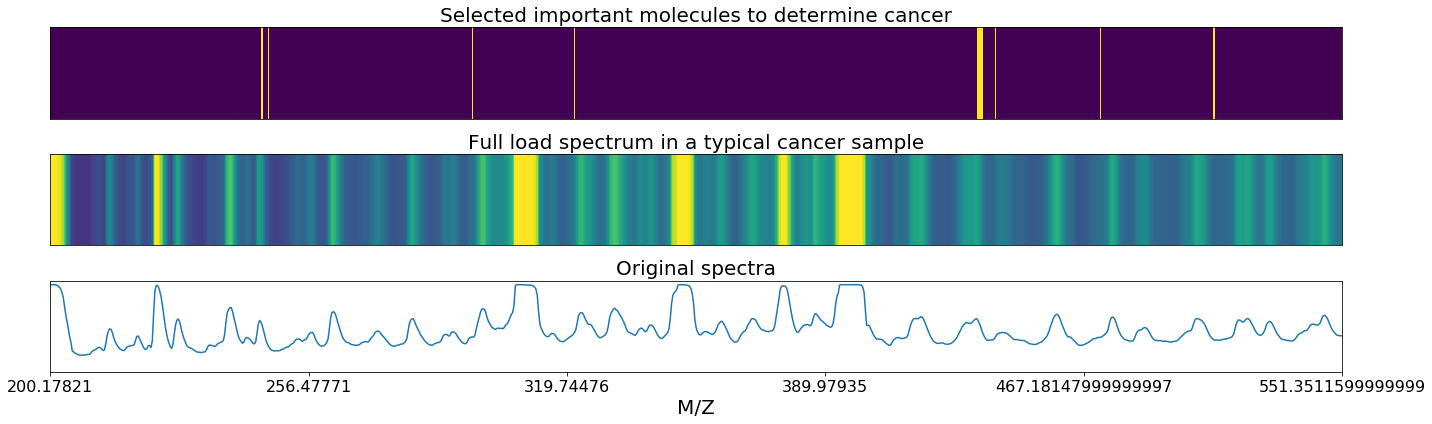

In [76]:
# Comparison of selected important masses and total mass spectra
plt.figure(figsize=(20,6))

plt.subplot(3,1,1)
plt.title('Selected important molecules to determine cancer', fontsize = 20)
plt.imshow(df_mass_important.loc[0][np.newaxis,:], aspect='auto')
_ = plt.xticks(np.arange(0,9000, 200), df_mass_important.columns[0:9000:200])
plt.xlim(0,1000)
plt.xticks([])
plt.yticks([])

plt.subplot(3,1,2)
plt.title('Full load spectrum in a typical cancer sample', fontsize = 20)
plt.imshow(df_transform, aspect='auto')
_ = plt.xticks(np.arange(0,9000, 200), df_mass_important.columns[0:9000:200])
plt.xlim(0,1000)
plt.xticks([])
plt.yticks([])

plt.subplot(3,1,3)
plt.title('Original spectra', fontsize = 20)
plt.plot(np.arange(df_transform.shape[1]), df_transform.values[0])
plt.xticks(np.arange(0,9000,200), df_transform.columns[0:9000:200], fontsize=16)
plt.xlim(0,1000)
plt.yticks([])
plt.xlabel('M/Z', fontsize = 20)

plt.tight_layout()

(array([ 12.,  12.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   1.,   0.,   8.,   0.,   0.,   0.,   0.,   4.,   2.,
          4.,   0.,   0.,   0.,   1.,   0.,   1.,   2.]),
 array([  245.8296 ,   549.95378,   854.07796,  1158.20214,  1462.32632,
         1766.4505 ,  2070.57468,  2374.69886,  2678.82304,  2982.94722,
         3287.0714 ,  3591.19558,  3895.31976,  4199.44394,  4503.56812,
         4807.6923 ,  5111.81648,  5415.94066,  5720.06484,  6024.18902,
         6328.3132 ,  6632.43738,  6936.56156,  7240.68574,  7544.80992,
         7848.9341 ,  8153.05828,  8457.18246,  8761.30664,  9065.43082,
         9369.555  ]),
 <a list of 30 Patch objects>)

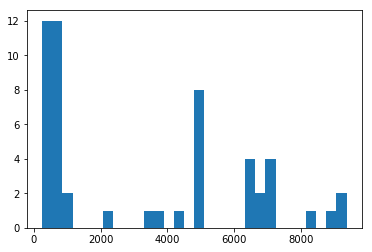

In [77]:
# Important mass distribution for ovarian data
plt.hist(mass_important_ovarian, bins=30)

(array([ 19.,   4.,   4.,   7.,   5.,   6.,   1.,   5.,   0.,   0.,   8.,
          1.,   1.,   4.,   1.,   1.,   3.,   4.,   0.,   1.,   2.,   2.,
          3.,   0.,   0.,   0.,   2.,   0.,   0.,   2.]),
 array([  228.5844 ,   543.97261,   859.36082,  1174.74903,  1490.13724,
         1805.52545,  2120.91366,  2436.30187,  2751.69008,  3067.07829,
         3382.4665 ,  3697.85471,  4013.24292,  4328.63113,  4644.01934,
         4959.40755,  5274.79576,  5590.18397,  5905.57218,  6220.96039,
         6536.3486 ,  6851.73681,  7167.12502,  7482.51323,  7797.90144,
         8113.28965,  8428.67786,  8744.06607,  9059.45428,  9374.84249,
         9690.2307 ]),
 <a list of 30 Patch objects>)

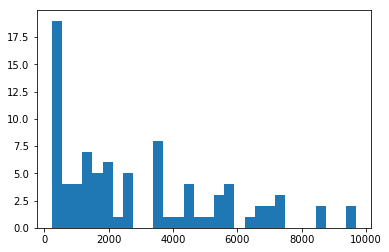

In [78]:
# Important mass distribution for ovarian data
plt.hist(mass_important_ovarian_hand, bins=30)

(array([ 3.,  9.,  1.,  0.,  2.,  2.,  1.,  0.,  1.,  3.,  4.,  1.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  2.,  0.,  0.,  0.,
         2.,  0.,  1.,  2.]),
 array([  322.08531 ,   642.553763,   963.022216,  1283.490669,
         1603.959122,  1924.427575,  2244.896028,  2565.364481,
         2885.832934,  3206.301387,  3526.76984 ,  3847.238293,
         4167.706746,  4488.175199,  4808.643652,  5129.112105,
         5449.580558,  5770.049011,  6090.517464,  6410.985917,
         6731.45437 ,  7051.922823,  7372.391276,  7692.859729,
         8013.328182,  8333.796635,  8654.265088,  8974.733541,
         9295.201994,  9615.670447,  9936.1389  ]),
 <a list of 30 Patch objects>)

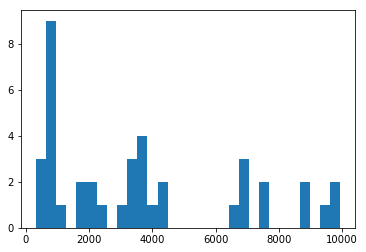

In [79]:
# Important mass distribution for prostate data
plt.hist(mass_important_prostate, bins=30)

<a id = 'roboticvshand'></a>
### [4.5 What is the advantange of using robotic sample preparation over sample preparation by hand?](#TOC)

It is well known that automation process could save cost and minimize human errors. Herein, we discussed this topic further by comparing robotic prepared ovarian samples and hand prepared ovarian samples and tried to provide a visual comparison between these two.

#### Comparison of mass spectra
We can easily tell that robotic prepared samples are much more consistant than hand prepared samples: Robotic prepared samples showed less variance among samples

* Spetra heamap of ovarian samples

Robotic Prepared Ovarian Samples


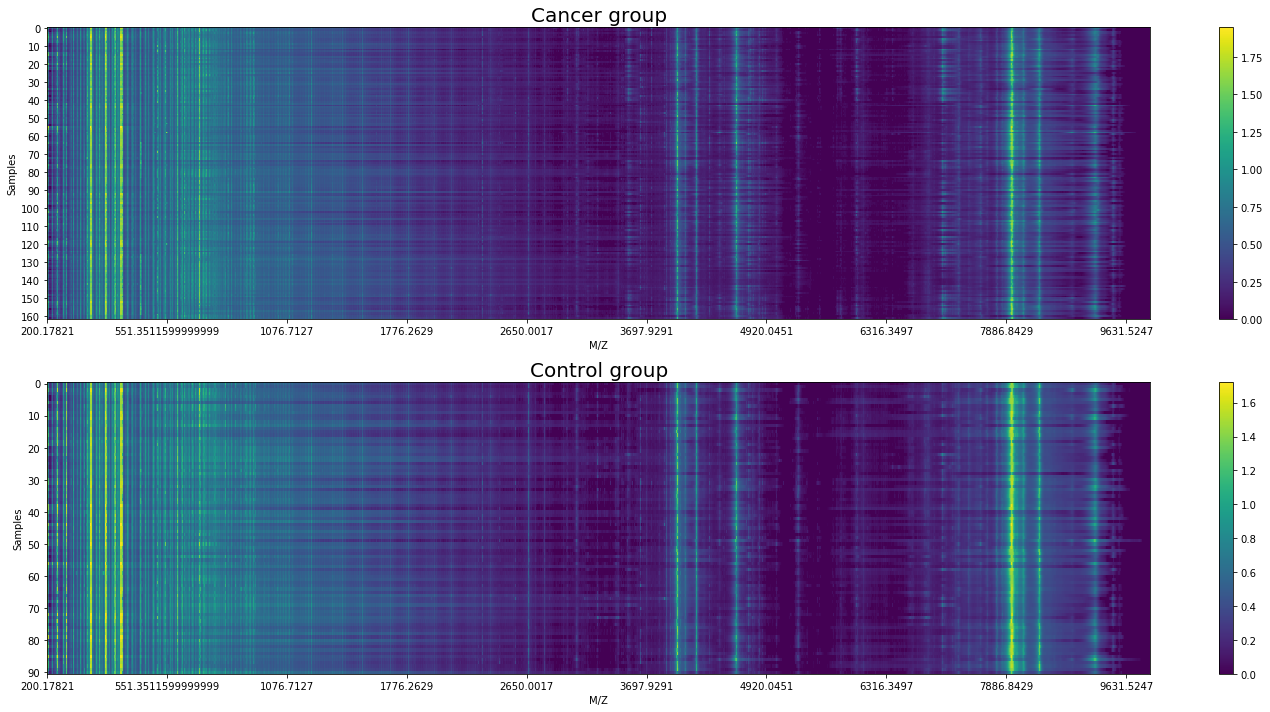

In [80]:
print('Robotic Prepared Ovarian Samples')
print('='*100)
heatmap(cancer_group, control_group)

* Spectra heamap of ovarian_hand samples

Hand Prepared Ovarian Samples


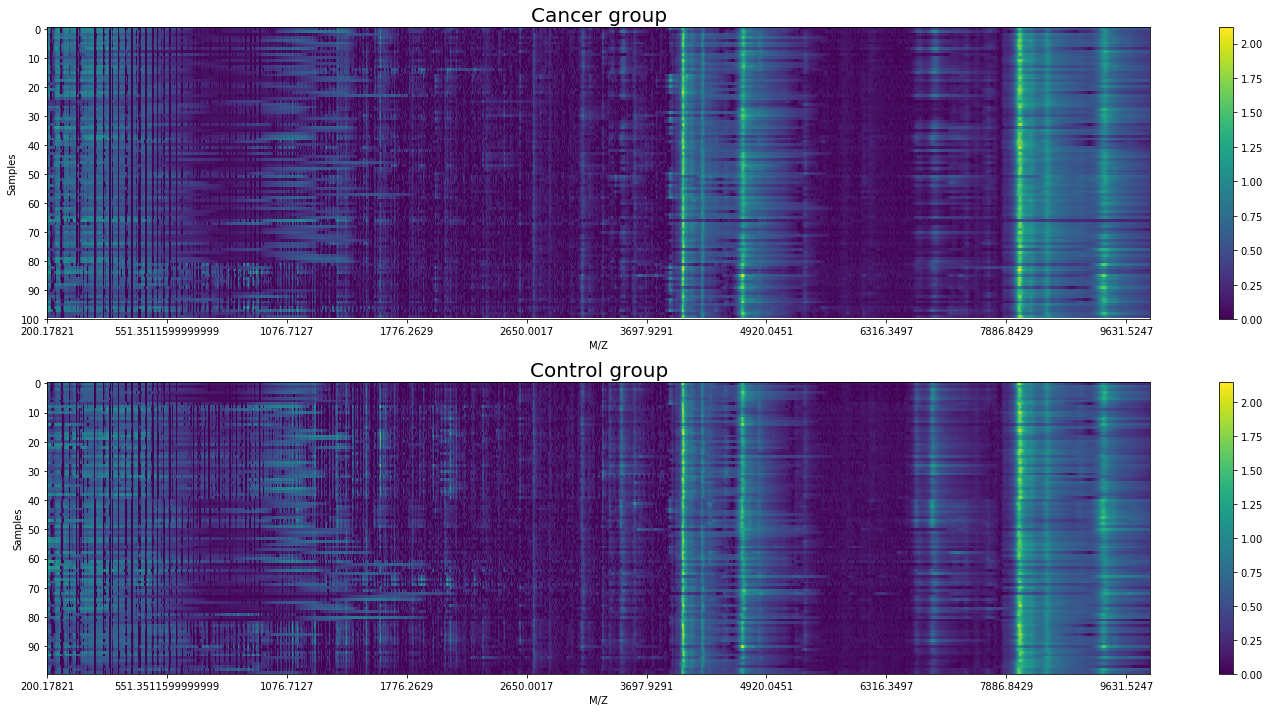

In [81]:
print('Hand Prepared Ovarian Samples')
print('='*100)
heatmap(cancer_group_hand, control_group_hand)

#### Comparison of classification using first two principle components
It is noted that cancer/non-cancer in robotic prepared samples are easily separable, but cancer and non-cancer groups are largely overlapped in hand prepared samples. The prediction of cancer/non-cancer is almost 100% using robotic prepared samples, while up to 95% accuracy of cancer/non-cancer prediction for hand prepared samples

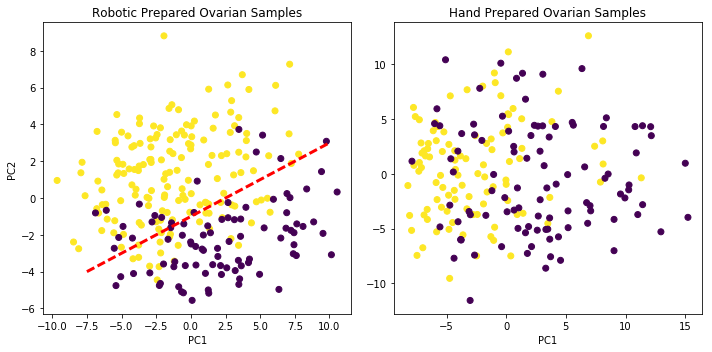

In [82]:
# Scatter plot of PC1 and PC2
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.title('Robotic Prepared Ovarian Samples')
plt.scatter(ovarian_data_transform[:,0], ovarian_data_transform[:,1], c=ovarian_label)
plt.plot([-7.5,10],[-4, 3],'r--',linewidth = 3)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.title('Hand Prepared Ovarian Samples')
plt.scatter(ovarian_data_hand_transform[:,0], ovarian_data_hand_transform[:,1], c=ovarian_label_hand)
plt.xlabel('PC1')
plt.tight_layout()

In [83]:
comparison = pd.DataFrame({'SVM':[accuracy_score(y_test_ovarian, svc_predict_ovarian), 
                                  roc_auc_score(y_test_ovarian, svc_predict_ovarian), 
                                  f1_score(y_test_ovarian, svc_predict_ovarian), 
                                  accuracy_score(y_test_ovarian_hand, svc_predict_ovarian_hand),  
                                  roc_auc_score(y_test_ovarian_hand, svc_predict_ovarian_hand), 
                                  f1_score(y_test_ovarian_hand, svc_predict_ovarian_hand)], 
                           'Random Forest':[accuracy_score(y_test_ovarian, rf_predict_ovarian), 
                                            roc_auc_score(y_test_ovarian, rf_predict_ovarian),
                                            f1_score(y_test_ovarian, rf_predict_ovarian),
                                            accuracy_score(y_test_ovarian_hand, rf_predict_ovarian_hand), 
                                            roc_auc_score(y_test_ovarian_hand, rf_predict_ovarian_hand),
                                            f1_score(y_test_ovarian_hand, rf_predict_ovarian_hand)], 
                           'KNN':[accuracy_score(y_test_ovarian, knn_predict_ovarian),
                                  roc_auc_score(y_test_ovarian, knn_predict_ovarian),
                                  f1_score(y_test_ovarian, knn_predict_ovarian), 
                                  accuracy_score(y_test_ovarian_hand, knn_predict_ovarian_hand), 
                                  roc_auc_score(y_test_ovarian_hand, knn_predict_ovarian_hand),
                                  f1_score(y_test_ovarian_hand, knn_predict_ovarian_hand)],
                           'Score': ['Accuracy', 'AUC', 'F1-Score','Accuracy', 'AUC', 'F1-Score'],
                           'Data':  np.repeat(['Ovarian','Ovarian hand'],[3,3])}).set_index(['Data','Score'])
print(comparison)

                            KNN  Random Forest       SVM
Data         Score                                      
Ovarian      Accuracy  0.986842       0.986842  1.000000
             AUC       0.989796       0.989796  1.000000
             F1-Score  0.989691       0.989691  1.000000
Ovarian hand Accuracy  0.933333       0.950000  0.950000
             AUC       0.927602       0.942308  0.942308
             F1-Score  0.942857       0.957746  0.957746


#### When mixing with other samples (e.g., prostate samples)
By visualization using the first two priciple components, we can see the robotic prepared samples are blue and dark blue, while hand_prepared ovarian samples are green and greenish blue. In theory, all ovarian samples should be classified to female group. But in this case, all the hand prepared ovarian samples were misclassified to male group and is widely spread out. In contrast, robotic prepared samples are much more aggregated and seperated well with male group.

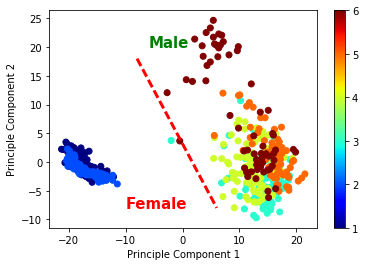

In [84]:
# Scatter plot using the first two principle components
plt.scatter(xdata_transform[:,0],xdata_transform[:,1], c = ylabels_original, cmap='jet')
plt.plot([-8,6],[18,-8], 'r--', linewidth = 3)
plt.annotate('Female',xy = [-10,-8], fontsize = 15, fontweight = 'bold', color = 'r')
plt.annotate('Male', xy = [-6,20], fontsize = 15, fontweight = 'bold', color = 'g')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar()

#### For prediction of molecular mass determining ovarian cancer
Only 52 features will explain more than 95% variance for robotic prepared ovarian samples and almost 90 features is needed for hand prepared ovarian samples. So by using robotic process, we can significantly increase the efficiency of screening for cancer related molecules.

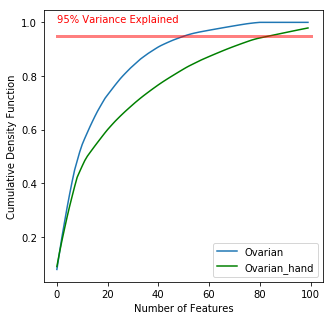

In [85]:
# Plot the cumulative explained variance of features

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(feature_importance_ovarian)[::-1][:100]), label = 'Ovarian')
plt.plot(np.cumsum(np.sort(feature_importance_ovarian_hand)[::-1][:100]), 'g', label ='Ovarian_hand')

plt.plot([0,100], [0.95, 0.95], color = 'r', linewidth = 3, alpha = 0.5)
plt.annotate('95% Variance Explained', xy=(0,1), xytext=(0,1), color = 'r')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Density Function')
plt.legend(loc='best')

<a id = 'fp and fn'></a>
### [4.5 What is the tradeoff between false positive and false negative in cancer diagonosis?](#TOC)

<font color='red'>False Negative</font>: The model predict the sample is not cancer, but the truth is cancer. Thus it is false negative error.<br>
<font color='red'>False Positive</font>: The model predict the sample is cancer, but the truth is not cancer. Thus it is false positive error.

Sensitivity or Recall or True Positive = TP/(TP+FN)<br>
Specificity = TN/(TN+FP)<br>
False Positive Rate = FP/(FP+TN) = 1 - Specificity<br>
Precision = TP/(TP+FP)<br>

In most times, for false positive and false negative, we have to choose which one is important than the other depending on situations. For example, for security alert, we need to reduce the false negative rate with increasing the false positive rate, e.g., we need to set the security alarm sensitive to any metals, including belt, keys, even those are not dangerous goods.<br>

For cancer diagnosis, we need to have lower false positive rate, because if the model has high false positive rate, a lot of healthy people will be falsely diagnosed as cancer, and further treatment by medicine or surgery will be costive to both patients and hospitals. Fortunately in our model, all the predictions are with both low false positive rate and low false negative rate, indicating our model is good for ovarian and prostate cancer prediction. 

<a id='conclusion'></a>
### [5. Conclusion](#TOC) 

For the prediction of ovarian and prostate cancers, best ML models(Ramdom Forest, SVM, KNN and ensemble model) were selected for robotic prepared ovarian samples, hand prepared ovarian samples and prostate samples, with prediction accuracy ranging from 93% to 100%. Best model for multiclassification (e.g, totally six groups) was selected to be SVM, achieving up to 93% of accuracy. We also successfully identified one of the fingerprint molecules determining ovarian cancer, which is confirmed by literature report: https://academic.oup.com/ajcp/article/134/6/903/1760577. In another word, we delvelped a tool to select potential fingerprint molecules for cancer diagnosis. This work not only offers *intuitive interpretion* of mass spectra data for non-professionals, but also will be a *powerful tool* for professionals to discover new fingerprint molecules for cancer diagnosis. Specifically, instead of focusing on all 9300 possible molecules, researchers could just focus on 52 molecules for ovarian cancer prediction, or 40 molecules for prostate cancer prediction, which will greatly improve R&D efficiency and save cost.